In [1]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np
from skimage.measure import block_reduce
import pywt

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

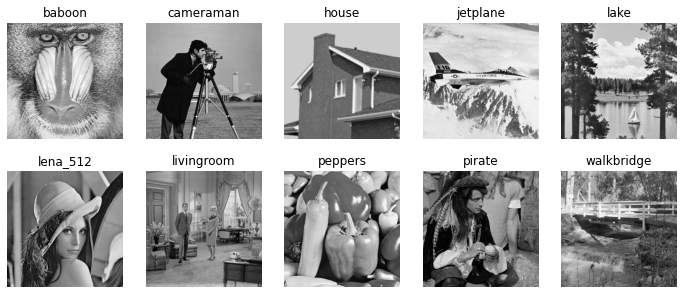

In [2]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [3]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])
dataset.shape

(10, 512, 512)

Делаем downsampling во имя производительности.

In [4]:
downsampling_scale = 2
d = 9 - downsampling_scale
n = 2 ** d
block_size = (2 ** downsampling_scale, 2 ** downsampling_scale)

dataset_new = np.empty((10, n, n), dtype=dataset.dtype)
for i in range(10):
    dataset_new[i] = np.round(block_reduce(dataset[i], block_size, np.mean))

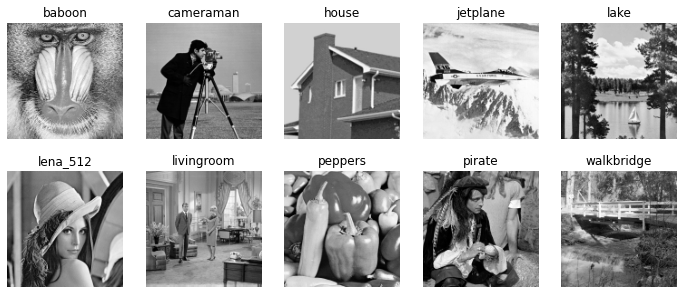

In [5]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(dataset_new[cnt], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

Анализ преобразования:
* Выполняем преобразование, получаем коэффициенты
* Перебираем значение порога $\delta$, для каждого $\delta$ считаем compress ratio. В статье Харюка 2014 года определение такое: $\frac{N^{nz}_w}{N_w}$ (отношение количества ненулевых элементов к общему количеству элементов), но это не очень логично и не реалистично (если судить по приведённым в статье графикам). Лучше будем использовать $\frac{N_w}{N^{nz}_w}$. Скажем, $CR=5$ означает, что мы сжали в 5 раз, и действительно: раньше у нас было $5n$ значений, а теперь лишь $n$ ненулевых. Так как у нас есть параметр сжатия $\delta$, то ненулевые значения у нас --- это те, которые больше $\delta$ по модулю.
* Все элементы, которые не больше $\delta$ по модулю, зануляем. Восстанавливаем обратным преобразованием картинку из сжатых коэффициентов.
* Считаем меру качества. PSNR для изображений хорошо подходит.
* Для разных дельт у нас 2 массива --- значения CR и значения PSNR. Строим график PSNR от CR. Собственно, дизайн эксперимента такой же, как в статье 2014 года.

$\delta$ растёт --- $CR$ растёт, так как мы не нулями считаем меньше элементов (а $CR$ ему обратно пропорционален). Также растёт ошибка (зануляем больше) и, соответственно, $PSNR$ падает.

Хотим: $CR$ побольше и $PSNR$ побольше.

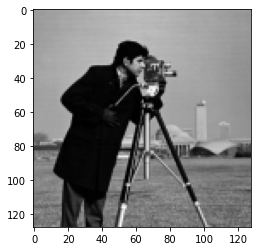

In [273]:
original = dataset_new[1]
plt.imshow(original, cmap='gray')

In [274]:
db_names = ['db2', 'db4', 'db6']
dbs = [pywt.Wavelet(name) for name in db_names]

In [275]:
modes = [2] * d

wtt_classic = wrappers.WTTwrapper(1) #классика
wtt_rpca_1 = wrappers.WTTwrapper(2) #просто RPCA вместо SVD
wtt_rpca_2 = wrappers.WTTwrapper(3) #RPCA с сохранением sparse-частей

algs = [
    wtt_classic,
    wtt_rpca_1,
    wtt_rpca_2
]

In [276]:
eps = 8e-2

In [277]:
for w in algs:
    w.adjust(
        original,
        d,
        modes,
        eps=eps,
        lambda_scale=1.2,
        is_2D=True
    )

In [278]:
preproc = wrappers.RPCA_preprocessing_wrapper(2)
wtt_for_preproc = wrappers.WTTwrapper(1)

vector, vector_modes = utils.matrix_to_vector(original, d, modes)
l, s, r = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=1.4,
    max_iter=150
)
l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]

wtt_for_preproc.adjust(l_matrix, d, modes, ranks=r, eps=eps, is_2D=True)
algs.append(wtt_for_preproc)

Применяем фильтры:

In [279]:
deltas = np.linspace(1e-2, 1e2, 200)

CR = [
    [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset_new.shape[0])
]
PSNR = [
    [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset_new.shape[0])
]

In [280]:
for cnt in range(10):
    original = dataset_new[cnt]
    coeffs_db = []
    coeffs = []
    for db in dbs:
        coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
    for w in algs:
        coeffs.append(w.apply(original, is_2D=True))
    for delta in deltas:
        for i in range(len(dbs)):
            arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
            thresholded = pywt.threshold(arr, delta, mode='hard')
            nnz = np.count_nonzero(thresholded)
            if nnz == 0:
                print('div by zero in cr')
                print('dbs, number=', i, 'delta=', delta)
            CR[cnt][i].append(thresholded.size * 1.0 / nnz)

            restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
            restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
            if nnz == original.size:
                print('div by zero in psnr')
                print('dbs, number=', i, 'delta=', delta)
            psnr_value = utils.psnr(original, restored)
            PSNR[cnt][i].append(psnr_value)

        for i in range(len(algs)):
            j = i + len(dbs)
            thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
            nnz = np.count_nonzero(thresholded)
            if nnz == 0:
                print('div by zero in cr')
                print('wtts, number =', i, 'delta=', delta)
            CR[cnt][j].append(original.size * 1.0 / nnz)

            restored = algs[i].apply_inverse(thresholded, is_2D=True)
            if nnz == original.size:
                print('div by zero in psnr')
                print('wtts, number =', i, 'delta=', delta)
            psnr_value = utils.psnr(original, restored)
            PSNR[cnt][j].append(psnr_value)

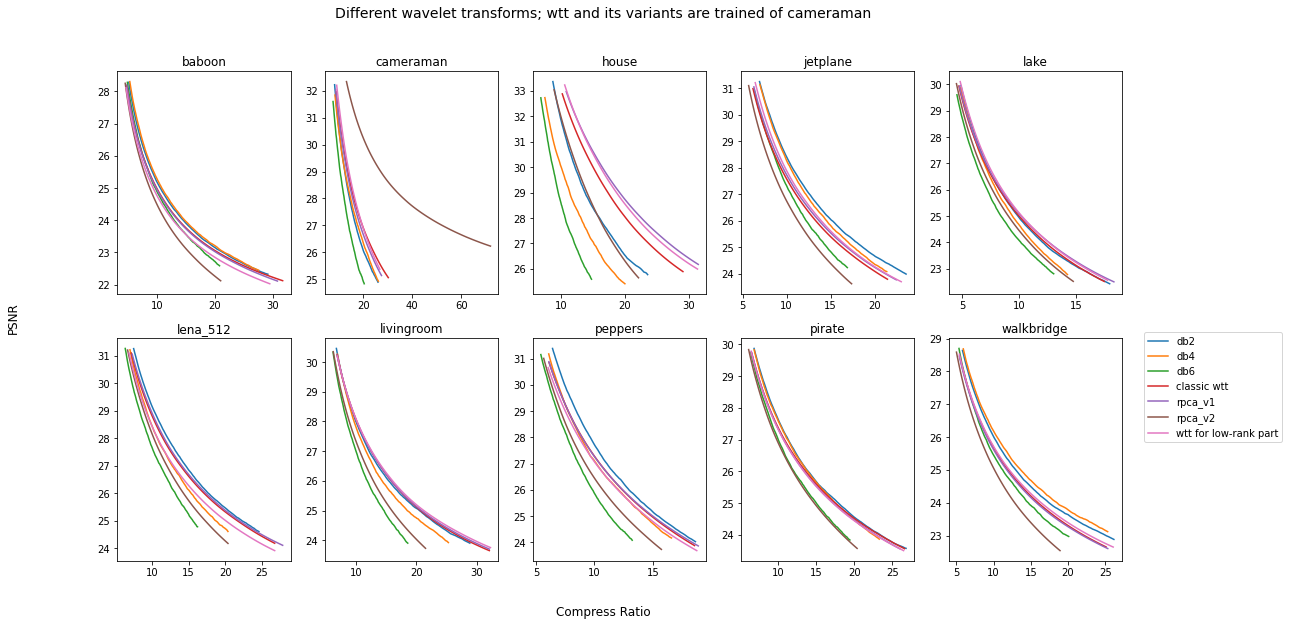

In [287]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 9))
cnt = 0
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']
for x in data:
    c1, c2 = cnt // ncols, cnt % ncols
    for i in range(len(alg_names)):       
        ax[c1, c2].plot(CR[cnt][i][50:150], PSNR[cnt][i][50:150], label=alg_names[i])
    ax[c1, c2].set_title(x)
    cnt += 1
fig.suptitle('Different wavelet transforms; wtt and its variants are trained of cameraman', fontsize=14)
fig.text(0.5, 0.04, "Compress Ratio", fontsize=12, color='black', ha='center')
fig.text(0.04, 0.5, "PSNR", fontsize=12, color='black', va='center', rotation='vertical')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

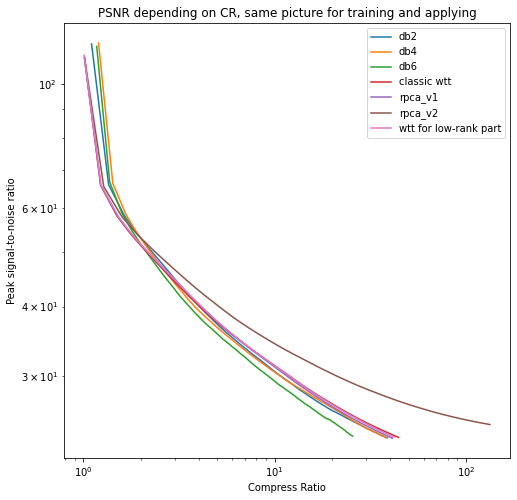

In [233]:
plt.figure(figsize=(8,8))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i], PSNR[i], label=alg_names[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, same picture for training and applying')
plt.legend()
plt.show()

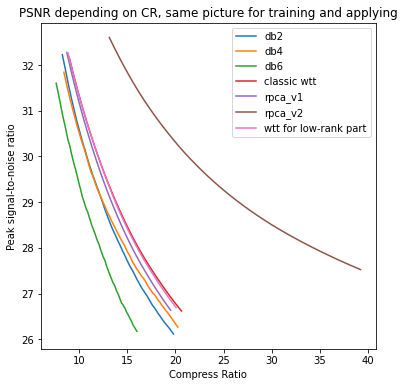

In [235]:
plt.figure(figsize=(6,6))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i][50:120], PSNR[i][50:120], label=alg_names[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, same picture for training and applying')
plt.legend()
plt.show()

Попробуем теперь применить к другой картинке:

In [236]:
original = dataset_new[4]

CR = [[] for _ in range(len(dbs) + len(algs))]
PSNR = [[] for _ in range(len(dbs) + len(algs))]

coeffs_db = []
coeffs = []
for db in dbs:
    coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
for w in algs:
    coeffs.append(w.apply(original, is_2D=True))

for delta in deltas:
    for i in range(len(dbs)):
        arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
        thresholded = pywt.threshold(arr, delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('dbs, number=', i, 'delta=', delta)
        CR[i].append(thresholded.size * 1.0 / nnz)
        
        restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
        restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
        if nnz == original.size:
            print('div by zero in psnr')
            print('dbs, number=', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[i].append(psnr_value)
        
    for i in range(len(algs)):
        j = i + len(dbs)
        thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('wtts, number =', i, 'delta=', delta)
        CR[j].append(original.size * 1.0 / nnz)
        
        restored = algs[i].apply_inverse(thresholded, is_2D=True)
        if nnz == original.size:
            print('div by zero in psnr')
            print('wtts, number =', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[j].append(psnr_value)

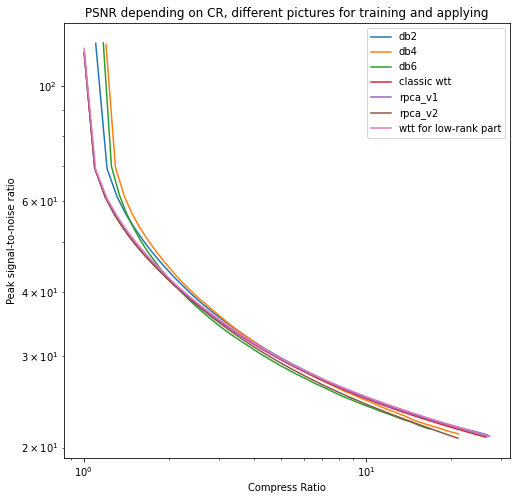

In [237]:
plt.figure(figsize=(8,8))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i], PSNR[i], label=alg_names[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, different pictures for training and applying')
plt.legend()
plt.show()

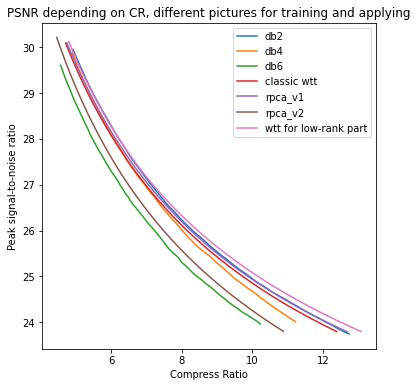

In [239]:
plt.figure(figsize=(6,6))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i][50:120], PSNR[i][50:120], label=alg_names[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, different pictures for training and applying')
plt.legend()
plt.show()

In [250]:
original = dataset_new[2]

CR = [[] for _ in range(len(dbs) + len(algs))]
PSNR = [[] for _ in range(len(dbs) + len(algs))]

coeffs_db = []
coeffs = []
for db in dbs:
    coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
for w in algs:
    coeffs.append(w.apply(original, is_2D=True))

for delta in deltas:
    for i in range(len(dbs)):
        arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
        thresholded = pywt.threshold(arr, delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('dbs, number=', i, 'delta=', delta)
        CR[i].append(thresholded.size * 1.0 / nnz)
        
        restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
        restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
        if nnz == original.size:
            print('div by zero in psnr')
            print('dbs, number=', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[i].append(psnr_value)
        
    for i in range(len(algs)):
        j = i + len(dbs)
        thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('wtts, number =', i, 'delta=', delta)
        CR[j].append(original.size * 1.0 / nnz)
        
        restored = algs[i].apply_inverse(thresholded, is_2D=True)
        if nnz == original.size:
            print('div by zero in psnr')
            print('wtts, number =', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[j].append(psnr_value)

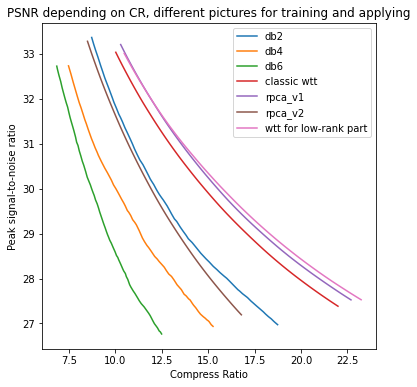

In [251]:
plt.figure(figsize=(6,6))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i][50:120], PSNR[i][50:120], label=alg_names[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, different pictures for training and applying')
plt.legend()
plt.show()

Попробуем внедрить препроцессинг.

Идея: вдруг мы, обучив фильтры на малоранговой части, сможем получить более универсальные фильтры для других изображений?

In [ ]:
CR_new = [[] for _ in range(2)]
PSNR_new = [[] for _ in range(2)]

original = dataset_new[1]
coeffs_1 = wtt_for_preproc.apply(original, is_2D=True)
original = dataset_new[4]
coeffs_2 = wtt_for_preproc.apply(original, is_2D=True)

for delta in deltas:
    thresholded = pywt.threshold(coeffs_1, delta, mode='hard')
    nnz = np.count_nonzero(thresholded)
    if nnz == 0:
        print('div by zero in cr')
        print('wtts, number =', i, 'delta=', delta)
    CR_new[0].append(original.size * 1.0 / nnz)

    restored = algs[i].apply_inverse(thresholded, is_2D=True)
    if nnz == original.size:
        print('div by zero in psnr')
        print('wtts, number =', i, 'delta=', delta)
    psnr_value = utils.psnr(original, restored)
    PSNR_new[0].append(psnr_value)
    
    thresholded = pywt.threshold(coeffs_2, delta, mode='hard')
    nnz = np.count_nonzero(thresholded)
    if nnz == 0:
        print('div by zero in cr')
        print('wtts, number =', i, 'delta=', delta)
    CR_new[1].append(original.size * 1.0 / nnz)

    restored = algs[i].apply_inverse(thresholded, is_2D=True)
    if nnz == original.size:
        print('div by zero in psnr')
        print('wtts, number =', i, 'delta=', delta)
    psnr_value = utils.psnr(original, restored)
    PSNR_new[0].append(psnr_value)